### Questão 3

Objetivo: Prever conexões futuras entre funcionários da rede.

O arquivo 'Future_Connections.csv' contém informações de futuras conexões de emails trocados pelos funcionários da empresa.

O índice é uma tupla indicando um par de nós que na rede não possuem conexão, e a coluna Future_Connection indica se uma aresta entre esses dois nós existirá no futuro, 1 indica conexão futura e 0 não.


Primeiro você deverá dividir os dados de treinamento e teste, depois será preciso criar uma matriz de características para as arestas encontradas em Future_Connection usando networkx, e então treinar um classificador para prever a probabilidade de uma aresta ser uma conexão futura.

A métrica de avaliação para esta questão é AUC.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle
import os
import tempfile
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
mpl.style.use('ggplot')
sns.set_style('white')
mpl.rcParams['figure.figsize'] = 12,8
warnings.simplefilter("ignore")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

/home/gsamenezes/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gsamenezes/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gsamenezes/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gsamenezes/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

In [2]:
G = nx.read_gpickle("email.gpickle")
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 753
Number of edges: 9746
Average degree:  25.8858


In [3]:
df = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
df.dropna(inplace=True)
df.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


In [4]:
nos = []
for tupla in df.index:
    nos.append(tupla[0])
    nos.append(tupla[1])
nos = np.array(nos)
nos = np.unique(nos)
print('O dataframe future-connections possui {} nós'.format(len(nos)))

O dataframe future-connections possui 1005 nós


In [5]:
# Mudar os nomes do índice para ficar de acordo com os nomes da rede:

def tupla_int_to_str(tupla):
    a=str(tupla[0])
    b=str(tupla[1])    
    return (a,b)

new_index = []
index = list(df.index)
for i in range(0, len(index)):
    new_index.append(tupla_int_to_str(index[i]))
df.index = new_index

In [6]:
# Vizinhos comuns:

common_neighbors = []
for tupla in df.index:
    try:
        common_neighbors.append(len(list(nx.common_neighbors(G, (tupla[0]), (tupla[1])))))
    except:
        common_neighbors.append(np.NaN)

In [7]:
# Calculando informações para predição de conexão futura
# (https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.link_prediction.html)

jaccard = []
resource_allocation=[]
adar=[]
pref_attach=[]
for tupla in df.index:
    try:
        a,b = nx.jaccard_coefficient(G, [tupla, tupla])
        jaccard.append(a[2])
    except:
        jaccard.append(np.NaN)
    try:
        c,d = nx.resource_allocation_index(G, [tupla, tupla])
        resource_allocation.append(c[2])
    except:
        resource_allocation.append(np.NaN)
    try:
        e,f = nx.adamic_adar_index(G, [tupla, tupla])
        adar.append(e[2])
    except:
        adar.append(np.NaN)
    try:
        g,h = nx.preferential_attachment(G, [tupla, tupla])
        pref_attach.append(g[2])
    except:
        pref_attach.append(np.NaN)

In [8]:
df['common_neighbors'] = common_neighbors
df['jaccard'] = jaccard
df['resource_allocation'] = resource_allocation
df['adar'] = adar
df['pref_attach'] = pref_attach

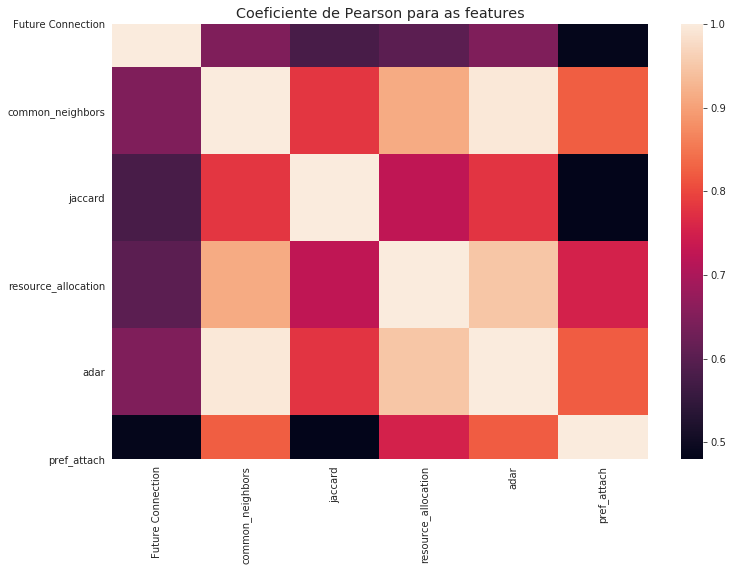

In [9]:
# Matriz de correlação

plt.figure(figsize=[12,8])
plt.title('Coeficiente de Pearson para as features')
sns.heatmap(df.corr())
plt.show()

In [10]:
# Avaliando o balanceamento do dataframe

neg, pos = np.bincount(df['Future Connection'])
total = neg + pos
print('Total: {}\n    Positivos: {} ({:.2f}% do total)\n'.format(
    total, pos, 100 * pos / total))

Total: 366334
    Positivos: 29332 (8.01% do total)



In [11]:
# Criando alguns dataframes

df1 = df.dropna()
df2 = df.fillna(0)
df3 = df.fillna(df.mean())

In [12]:
# Construindo uma rede neural

EPOCHS = 100
BATCH_SIZE = 1024

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
        16, activation='relu',
        input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
        bias_initializer=output_bias),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [13]:
# Especificando parâmetros para parar o treinamento

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [14]:
# É razoável colocar o parâmetro "b" adequado baseado na desproporcionalidade das duas classes

def find_initial_bias(df):
    neg, pos = np.bincount(df['Future Connection'])
    initial_bias = np.log([pos/neg])
    return initial_bias

In [15]:
def df_to_train_test(df, target):

    # Separando os dataframes

    train_df, test_df = train_test_split(df, test_size=0.3)
    train_df, val_df = train_test_split(train_df, test_size=0.2)

    # Transformando os dataframes em numpy arrays

    train_labels = np.array(train_df.pop(target))
    val_labels = np.array(val_df.pop(target))
    test_labels = np.array(test_df.pop(target))

    train_features = np.array(train_df)
    val_features = np.array(val_df)
    test_features = np.array(test_df)

    # Colocando os números em escala

    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)
    
    return train_labels, val_labels, test_labels, train_features, val_features, test_features

In [16]:
# Função para plotar como o modelo se comporta em cada época

def plot_metrics(history):
    plt.figure(figsize=[15,7.5])
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.grid()
        plt.legend()

In [17]:
# Plotar a curva ROC

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

Avaliando o para o dataframe em que os NaN foram removidos:

In [34]:
train_labels, val_labels, test_labels, train_features, val_features, test_features = df_to_train_test(df1, 'Future Connection')

In [38]:
%%time
with tf.device('/cpu'):
    model_drop_nan = make_model(output_bias = find_initial_bias(df1))
    baseline_history_drop_nan = model_drop_nan.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
#         callbacks = [early_stopping],
        validation_data=(val_features, val_labels))

Train on 115167 samples, validate on 28792 samples
Epoch 1/100
115167/115167 [==============================] - 1s 5us/sample - loss: 0.2367 - tp: 1642.0000 - fp: 206.0000 - tn: 105454.0000 - fn: 7865.0000 - accuracy: 0.9299 - precision: 0.8885 - recall: 0.1727 - auc: 0.7259 - val_loss: 0.1700 - val_tp: 936.0000 - val_fp: 80.0000 - val_tn: 26348.0000 - val_fn: 1428.0000 - val_accuracy: 0.9476 - val_precision: 0.9213 - val_recall: 0.3959 - val_auc: 0.9033
Epoch 2/100
115167/115167 [==============================] - 0s 3us/sample - loss: 0.1811 - tp: 3893.0000 - fp: 1018.0000 - tn: 104642.0000 - fn: 5614.0000 - accuracy: 0.9424 - precision: 0.7927 - recall: 0.4095 - auc: 0.8782 - val_loss: 0.1525 - val_tp: 1188.0000 - val_fp: 167.0000 - val_tn: 26261.0000 - val_fn: 1176.0000 - val_accuracy: 0.9534 - val_precision: 0.8768 - val_recall: 0.5025 - val_auc: 0.9056
Epoch 3/100
115167/115167 [==============================] - 0s 3us/sample - loss: 0.1702 - tp: 4305.0000 - fp: 1094.0000 - tn: 10

Epoch 21/100
115167/115167 [==============================] - 0s 3us/sample - loss: 0.1557 - tp: 4727.0000 - fp: 1014.0000 - tn: 104646.0000 - fn: 4780.0000 - accuracy: 0.9497 - precision: 0.8234 - recall: 0.4972 - auc: 0.8970 - val_loss: 0.1425 - val_tp: 1300.0000 - val_fp: 236.0000 - val_tn: 26192.0000 - val_fn: 1064.0000 - val_accuracy: 0.9548 - val_precision: 0.8464 - val_recall: 0.5499 - val_auc: 0.9060
Epoch 22/100
115167/115167 [==============================] - 0s 3us/sample - loss: 0.1556 - tp: 4746.0000 - fp: 994.0000 - tn: 104666.0000 - fn: 4761.0000 - accuracy: 0.9500 - precision: 0.8268 - recall: 0.4992 - auc: 0.8969 - val_loss: 0.1424 - val_tp: 1303.0000 - val_fp: 242.0000 - val_tn: 26186.0000 - val_fn: 1061.0000 - val_accuracy: 0.9547 - val_precision: 0.8434 - val_recall: 0.5512 - val_auc: 0.9063
Epoch 23/100
115167/115167 [==============================] - 0s 3us/sample - loss: 0.1564 - tp: 4749.0000 - fp: 1010.0000 - tn: 104650.0000 - fn: 4758.0000 - accuracy: 0.9499 -

Epoch 41/100
115167/115167 [==============================] - 0s 2us/sample - loss: 0.1545 - tp: 4797.0000 - fp: 930.0000 - tn: 104730.0000 - fn: 4710.0000 - accuracy: 0.9510 - precision: 0.8376 - recall: 0.5046 - auc: 0.8969 - val_loss: 0.1421 - val_tp: 1312.0000 - val_fp: 255.0000 - val_tn: 26173.0000 - val_fn: 1052.0000 - val_accuracy: 0.9546 - val_precision: 0.8373 - val_recall: 0.5550 - val_auc: 0.9053
Epoch 42/100
115167/115167 [==============================] - 0s 2us/sample - loss: 0.1540 - tp: 4800.0000 - fp: 953.0000 - tn: 104707.0000 - fn: 4707.0000 - accuracy: 0.9509 - precision: 0.8343 - recall: 0.5049 - auc: 0.8970 - val_loss: 0.1422 - val_tp: 1305.0000 - val_fp: 250.0000 - val_tn: 26178.0000 - val_fn: 1059.0000 - val_accuracy: 0.9545 - val_precision: 0.8392 - val_recall: 0.5520 - val_auc: 0.9052
Epoch 43/100
115167/115167 [==============================] - 0s 3us/sample - loss: 0.1541 - tp: 4776.0000 - fp: 923.0000 - tn: 104737.0000 - fn: 4731.0000 - accuracy: 0.9509 - p

Epoch 61/100
115167/115167 [==============================] - 0s 3us/sample - loss: 0.1535 - tp: 4857.0000 - fp: 882.0000 - tn: 104778.0000 - fn: 4650.0000 - accuracy: 0.9520 - precision: 0.8463 - recall: 0.5109 - auc: 0.8962 - val_loss: 0.1421 - val_tp: 1306.0000 - val_fp: 246.0000 - val_tn: 26182.0000 - val_fn: 1058.0000 - val_accuracy: 0.9547 - val_precision: 0.8415 - val_recall: 0.5525 - val_auc: 0.9054
Epoch 62/100
115167/115167 [==============================] - 0s 3us/sample - loss: 0.1525 - tp: 4881.0000 - fp: 876.0000 - tn: 104784.0000 - fn: 4626.0000 - accuracy: 0.9522 - precision: 0.8478 - recall: 0.5134 - auc: 0.8960 - val_loss: 0.1421 - val_tp: 1299.0000 - val_fp: 242.0000 - val_tn: 26186.0000 - val_fn: 1065.0000 - val_accuracy: 0.9546 - val_precision: 0.8430 - val_recall: 0.5495 - val_auc: 0.9055
Epoch 63/100
115167/115167 [==============================] - 0s 3us/sample - loss: 0.1528 - tp: 4864.0000 - fp: 906.0000 - tn: 104754.0000 - fn: 4643.0000 - accuracy: 0.9518 - p

Epoch 81/100
115167/115167 [==============================] - 0s 3us/sample - loss: 0.1531 - tp: 4888.0000 - fp: 901.0000 - tn: 104759.0000 - fn: 4619.0000 - accuracy: 0.9521 - precision: 0.8444 - recall: 0.5141 - auc: 0.8976 - val_loss: 0.1421 - val_tp: 1287.0000 - val_fp: 229.0000 - val_tn: 26199.0000 - val_fn: 1077.0000 - val_accuracy: 0.9546 - val_precision: 0.8489 - val_recall: 0.5444 - val_auc: 0.9054
Epoch 82/100
115167/115167 [==============================] - 0s 2us/sample - loss: 0.1521 - tp: 4894.0000 - fp: 898.0000 - tn: 104762.0000 - fn: 4613.0000 - accuracy: 0.9521 - precision: 0.8450 - recall: 0.5148 - auc: 0.8981 - val_loss: 0.1420 - val_tp: 1298.0000 - val_fp: 241.0000 - val_tn: 26187.0000 - val_fn: 1066.0000 - val_accuracy: 0.9546 - val_precision: 0.8434 - val_recall: 0.5491 - val_auc: 0.9055
Epoch 83/100
115167/115167 [==============================] - 0s 2us/sample - loss: 0.1529 - tp: 4893.0000 - fp: 895.0000 - tn: 104765.0000 - fn: 4614.0000 - accuracy: 0.9522 - p

CPU times: user 2min 11s, sys: 13.6 s, total: 2min 25s
Wall time: 32.1 s


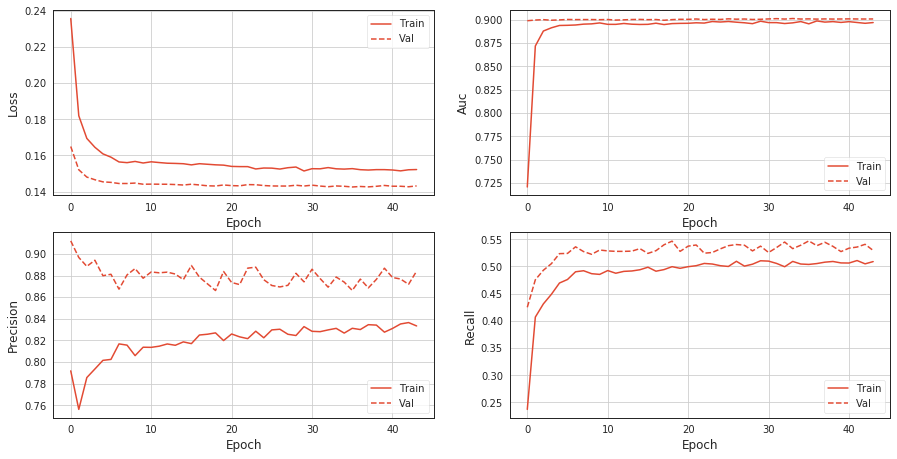

In [20]:
plot_metrics(baseline_history_drop_nan)

Percebe-se que o modelo apresenta bons resultados, dado que os valores são muito semelhantes nos datasets de treino e validação.

In [21]:
# Avaliando o modelo no dataset de treinamento

baseline_results_drop_nan = model_drop_nan.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)

pd.DataFrame({'Metrics': model_drop_nan.metrics_names, 'Results': baseline_results_drop_nan})

,Metrics,Results
0,loss,0.142861
1,tp,2805.000000
2,fp,415.000000
3,tn,56145.000000
4,fn,2332.000000
5,accuracy,0.955476
6,precision,0.871118
7,recall,0.546039
8,auc,0.907389


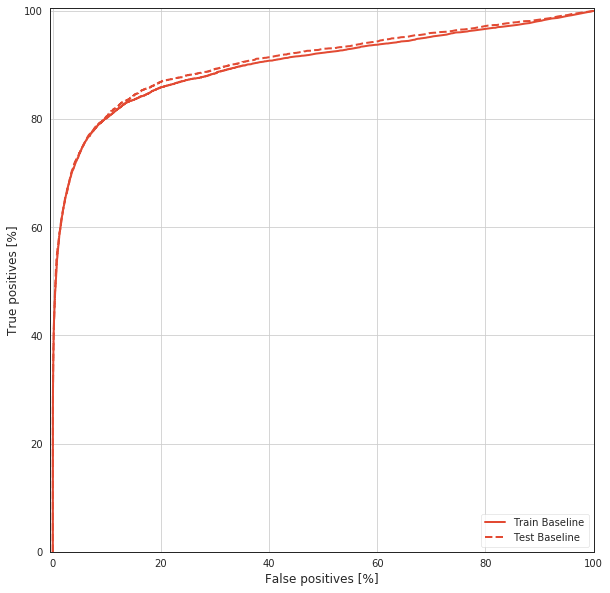

In [22]:
# Predições

train_predictions_baseline = model_drop_nan.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model_drop_nan.predict(test_features, batch_size=BATCH_SIZE)

plt.figure(figsize=[20,10])
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

Por fim, o modelo se comporta de maneira bastante homogênea no dataset de teste.

Avaliando para o dataframe em que os NaN foram preenchidos com 0

In [23]:
train_labels, val_labels, test_labels, train_features, val_features, test_features = df_to_train_test(df2, 'Future Connection')

In [24]:
model_fill_0 = make_model(output_bias = find_initial_bias(df2))
baseline_history_fill_0 = model_drop_nan.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Train on 205146 samples, validate on 51287 samples
Epoch 1/100
205146/205146 [==============================] - 0s 2us/sample - loss: 0.2164 - tp: 4967.0000 - fp: 1155.0000 - tn: 187556.0000 - fn: 11468.0000 - accuracy: 0.9385 - precision: 0.8113 - recall: 0.3022 - auc: 0.7146 - val_loss: 0.2108 - val_tp: 1227.0000 - val_fp: 189.0000 - val_tn: 47033.0000 - val_fn: 2838.0000 - val_accuracy: 0.9410 - val_precision: 0.8665 - val_recall: 0.3018 - val_auc: 0.7374
Epoch 2/100
205146/205146 [==============================] - 0s 2us/sample - loss: 0.2137 - tp: 4854.0000 - fp: 1049.0000 - tn: 187662.0000 - fn: 11581.0000 - accuracy: 0.9384 - precision: 0.8223 - recall: 0.2953 - auc: 0.7228 - val_loss: 0.2104 - val_tp: 1261.0000 - val_fp: 220.0000 - val_tn: 47002.0000 - val_fn: 2804.0000 - val_accuracy: 0.9410 - val_precision: 0.8515 - val_recall: 0.3102 - val_auc: 0.7141
Epoch 3/100
205146/205146 [==============================] - 0s 2us/sample - loss: 0.2133 - tp: 4930.0000 - fp: 1023.0000 - t

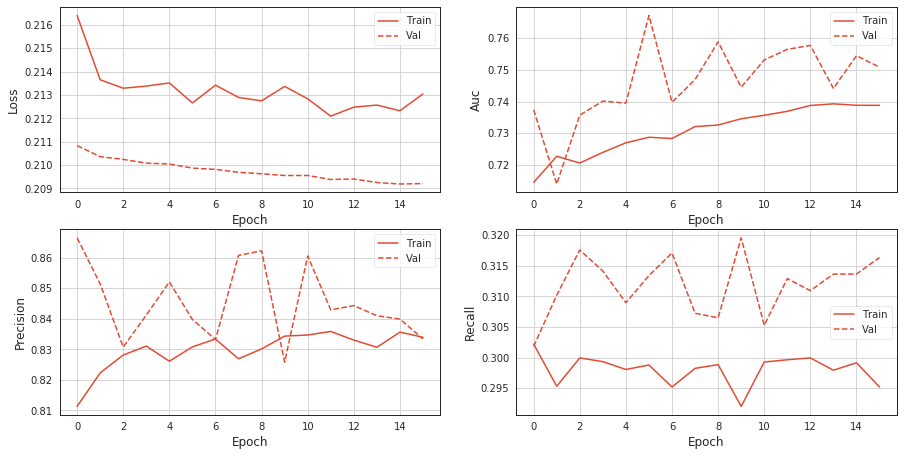

In [25]:
plot_metrics(baseline_history_fill_0)

In [26]:
# Avaliando o modelo no dataset de treinamento

baseline_results_fill_0 = model_fill_0.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)

pd.DataFrame({'Metrics': model_fill_0.metrics_names, 'Results': baseline_results_fill_0})

,Metrics,Results
0,loss,0.306424
1,tp,0.000000
2,fp,0.000000
3,tn,101069.000000
4,fn,8832.000000
5,accuracy,0.919637
6,precision,0.000000
7,recall,0.000000
8,auc,0.290321


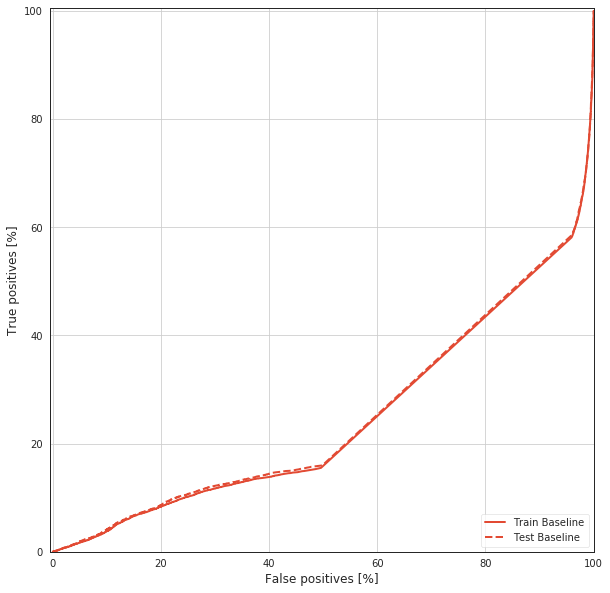

In [27]:
# Predições

train_predictions_baseline = model_fill_0.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model_fill_0.predict(test_features, batch_size=BATCH_SIZE)

plt.figure(figsize=[20,10])
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

Percebe-se que a estratégia de preencher com 0 não funcionou.

Avaliando para o dataframe em que os NaN foram preenchidos com a média

In [28]:
train_labels, val_labels, test_labels, train_features, val_features, test_features = df_to_train_test(df3, 'Future Connection')

In [29]:
model_fill_mean = make_model(output_bias = find_initial_bias(df3))
baseline_history_fill_mean = model_drop_nan.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Train on 205146 samples, validate on 51287 samples
Epoch 1/100
205146/205146 [==============================] - 0s 2us/sample - loss: 0.2069 - tp: 4819.0000 - fp: 947.0000 - tn: 187853.0000 - fn: 11527.0000 - accuracy: 0.9392 - precision: 0.8358 - recall: 0.2948 - auc: 0.7899 - val_loss: 0.2020 - val_tp: 1291.0000 - val_fp: 191.0000 - val_tn: 46934.0000 - val_fn: 2871.0000 - val_accuracy: 0.9403 - val_precision: 0.8711 - val_recall: 0.3102 - val_auc: 0.7972
Epoch 2/100
205146/205146 [==============================] - 0s 2us/sample - loss: 0.2055 - tp: 4789.0000 - fp: 929.0000 - tn: 187871.0000 - fn: 11557.0000 - accuracy: 0.9391 - precision: 0.8375 - recall: 0.2930 - auc: 0.7934 - val_loss: 0.2014 - val_tp: 1290.0000 - val_fp: 192.0000 - val_tn: 46933.0000 - val_fn: 2872.0000 - val_accuracy: 0.9403 - val_precision: 0.8704 - val_recall: 0.3099 - val_auc: 0.7991
Epoch 3/100
205146/205146 [==============================] - 0s 2us/sample - loss: 0.2046 - tp: 4808.0000 - fp: 928.0000 - tn: 

Epoch 21/100
205146/205146 [==============================] - 0s 2us/sample - loss: 0.2045 - tp: 4761.0000 - fp: 922.0000 - tn: 187878.0000 - fn: 11585.0000 - accuracy: 0.9390 - precision: 0.8378 - recall: 0.2913 - auc: 0.7971 - val_loss: 0.2010 - val_tp: 1285.0000 - val_fp: 193.0000 - val_tn: 46932.0000 - val_fn: 2877.0000 - val_accuracy: 0.9401 - val_precision: 0.8694 - val_recall: 0.3087 - val_auc: 0.8008
Epoch 22/100
205146/205146 [==============================] - 0s 2us/sample - loss: 0.2044 - tp: 4822.0000 - fp: 964.0000 - tn: 187836.0000 - fn: 11524.0000 - accuracy: 0.9391 - precision: 0.8334 - recall: 0.2950 - auc: 0.7969 - val_loss: 0.2010 - val_tp: 1284.0000 - val_fp: 188.0000 - val_tn: 46937.0000 - val_fn: 2878.0000 - val_accuracy: 0.9402 - val_precision: 0.8723 - val_recall: 0.3085 - val_auc: 0.8010
Epoch 23/100
205146/205146 [==============================] - 0s 2us/sample - loss: 0.2042 - tp: 4807.0000 - fp: 916.0000 - tn: 187884.0000 - fn: 11539.0000 - accuracy: 0.9393 

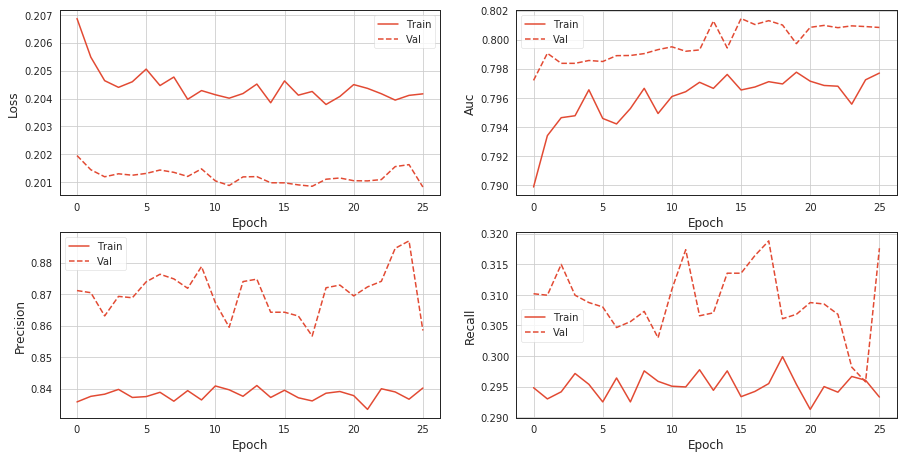

In [30]:
plot_metrics(baseline_history_fill_mean)

In [31]:
# Avaliando o modelo no dataset de treinamento

baseline_results_fill_mean = model_fill_mean.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)

pd.DataFrame({'Metrics': model_fill_mean.metrics_names, 'Results': baseline_results_fill_mean})

,Metrics,Results
0,loss,0.214329
1,tp,1740.000000
2,fp,152.000000
3,tn,100925.000000
4,fn,7084.000000
5,accuracy,0.934159
6,precision,0.919662
7,recall,0.197189
8,auc,0.781570


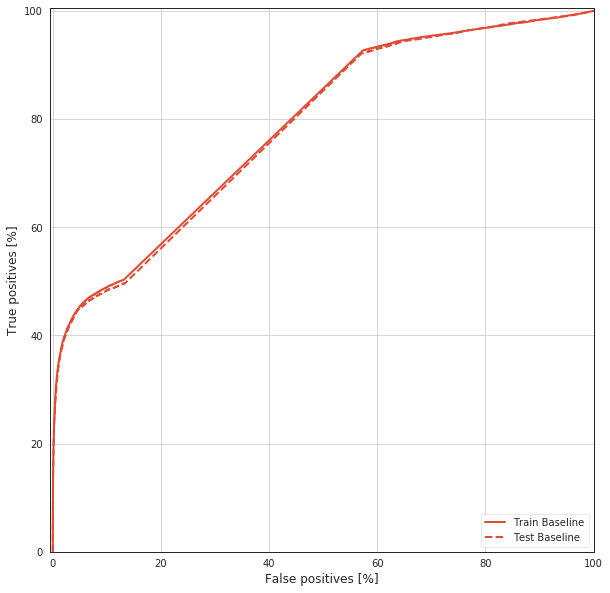

In [32]:
# Predições

train_predictions_baseline = model_fill_mean.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model_fill_mean.predict(test_features, batch_size=BATCH_SIZE)

plt.figure(figsize=[20,10])
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

Percebe-se que esse foi um metódo ainda pior.

In [33]:
# Comparação entre os três modelos

pd.DataFrame({'Metrics': model_fill_mean.metrics_names, 
              'Drop NaN': baseline_results_drop_nan,
              'Fill 0': baseline_results_fill_0,
              'Fill Mean': baseline_results_fill_mean})

,Metrics,Drop NaN,Fill 0,Fill Mean
0,loss,0.142861,0.306424,0.214329
1,tp,2805.000000,0.000000,1740.000000
2,fp,415.000000,0.000000,152.000000
3,tn,56145.000000,101069.000000,100925.000000
4,fn,2332.000000,8832.000000,7084.000000
5,accuracy,0.955476,0.919637,0.934159
6,precision,0.871118,0.000000,0.919662
7,recall,0.546039,0.000000,0.197189
8,auc,0.907389,0.290321,0.781570
